**Cell 1:**
This cell installs necessary libraries Setup and Configuration parameters like file paths, image size, and training constants

In [1]:
# !pip install optuna-integration[tfkeras] --no-deps
!pip install optuna-integration[tfkeras]
!pip install opencv-python --no-deps

import os
import shutil
import numpy as np
import pandas as pd
import optuna
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 

# TensorFlow/Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop 
from optuna.integration.tfkeras import TFKerasPruningCallback


import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# --- CONFIGURATION (START) ---
KAGGLE_INPUT_PATH = '/kaggle/input/lung-cancer-dataset-with-augmentation'
DATASET_ROOT = os.path.join(KAGGLE_INPUT_PATH, 'Lung Cancer Dataset')

# Original directories (read-only)
TRAIN_DIR = os.path.join(DATASET_ROOT, 'Train')
ORIGINAL_TEST_DIR = os.path.join(DATASET_ROOT, 'Test') 

# New directories must be created in the writeable working directory
WORKING_DIR = '/kaggle/working'
VAL_DIR = os.path.join(WORKING_DIR, 'Val_50_percent')
FINAL_TEST_DIR = os.path.join(WORKING_DIR, 'Final_Test_50_percent')

# Hyperparameters and settings
IMAGE_SIZE = (300, 300)
NUM_CLASSES = 3
SEED = 42
EPOCHS_PER_TRIAL = 3   # <-- REDUCED FROM 5 TO 3 FOR STABILITY
INITIAL_EPOCHS = 25   
FINE_TUNE_EPOCHS = 15 
N_TRIALS = 15          # <-- REDUCED FROM 30 TO 15 FOR STABILITY
N_TRIALS_FREEZE = 5    # <-- REDUCED FROM 10 TO 5 FOR STABILITY
FINAL_WEIGHT_DECAY = 0.0 

# Set seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASS_NAMES = ['Bengin cases', 'Malignant cases', 'Normal cases']

print(f"Configuration complete. Epochs and Trials reduced for stability. Image Size: {IMAGE_SIZE}, Classes: {NUM_CLASSES}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptograph

2025-12-04 06:29:31.780546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764829771.974409      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764829772.034747      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Configuration complete. Epochs and Trials reduced for stability. Image Size: (300, 300), Classes: 3


**Cell 2: Dataset Splitting (Original Test ----- Val and Final Test)**


This cell takes the original read-only 'Test' folder and splits its images $50/50$ into a new 'Val' folder (for model tuning/validation) and a 'Final_Test' folder (for final, unbiased evaluation).

In [ ]:
print("## 1. 📂 Splitting Original Test Data (50/50) into Val and Final Test Sets")

# Ensure working directories exist and are clean
for d in [VAL_DIR, FINAL_TEST_DIR]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

for class_name in CLASS_NAMES:
    class_path = os.path.join(ORIGINAL_TEST_DIR, class_name)
    if not os.path.exists(class_path):
        print(f"Error: Directory not found: {class_path}")
        continue
    
    # Get all image files in the current class folder
    all_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split the files 50/50
    val_files, test_files = train_test_split(
        all_files, 
        test_size=0.5, 
        random_state=SEED
    )
    
    # Create class subdirectories in the new folders
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(FINAL_TEST_DIR, class_name), exist_ok=True)

    # Copy files to the respective new directories
    for f in val_files:
        shutil.copy(f, os.path.join(VAL_DIR, class_name, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(FINAL_TEST_DIR, class_name, os.path.basename(f)))

print(f"Split complete. New folders created: 'Val_50_percent' and 'Final_Test_50_percent'.")

## 1. 📂 Splitting Original Test Data (50/50) into Val and Final Test Sets
Split complete. New folders created: 'Val_50_percent' and 'Final_Test_50_percent'.


**Cell 3: Model Architecture Function**

This function builds the EfficientNetB3 model for transfer learning. It loads weights from the pre-trained ImageNet dataset, freezes the base model, and adds custom output layers (the "head") for classification.

In [3]:
def build_efficientnet_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Builds the EfficientNetB3 model for transfer learning with a custom classification head.
    The base model is initially set to non-trainable (frozen).
    """
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False, 
        input_shape=input_shape
    )
    
    base_model.trainable = False 

    # Add the new classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate, name="dropout_1")(x) 
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dropout(dropout_rate/2, name="dropout_2")(x) 
    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

print("Model builder function 'build_efficientnet_model' defined.")

Model builder function 'build_efficientnet_model' defined.


**Cell 4: Data Split Verification and Data Loader Setup**

This cell confirms the number of images in the Train, Validation, and Final Test sets after the split, and checks the class balance. Data generators are set up here only for counting, before the Optuna search begins.

In [4]:
print("\n## 4. 🔍 Data Split Verification")

# Data Generators for accurate image counting and basic normalization
train_gen_for_counts = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', seed=SEED, shuffle=True
)
val_gen_for_counts = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', seed=SEED, shuffle=False
)
final_test_gen_for_counts = ImageDataGenerator(rescale=1./255).flow_from_directory(
    FINAL_TEST_DIR, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', seed=SEED, shuffle=False
)

print(f"  Total Images: Train Count: {train_gen_for_counts.n}, Validation Count: {val_gen_for_counts.n}, Test Count: {final_test_gen_for_counts.n}")

print("\n--- Detailed Class Counts ---")

def get_class_counts(generator, set_name):
    """Helper function to print detailed class counts for a generator."""
    idx_to_class = {v: k for k, v in generator.class_indices.items()}
    counts = np.bincount(generator.classes)
    
    print(f"📊 {set_name} Set:")
    for idx, count in enumerate(counts):
        if idx in idx_to_class:
            print(f"  - {idx_to_class[idx]}: {count} images")

get_class_counts(train_gen_for_counts, "Train")
get_class_counts(val_gen_for_counts, "Validation")
get_class_counts(final_test_gen_for_counts, "Test")
print("Data loaders setup and counts verified.")


## 4. 🔍 Data Split Verification
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
  Total Images: Train Count: 3508, Validation Count: 151, Test Count: 153

--- Detailed Class Counts ---
📊 Train Set:
  - Bengin cases: 1140 images
  - Malignant cases: 1195 images
  - Normal cases: 1173 images
📊 Validation Set:
  - Bengin cases: 10 images
  - Malignant cases: 104 images
  - Normal cases: 37 images
📊 Test Set:
  - Bengin cases: 10 images
  - Malignant cases: 105 images
  - Normal cases: 38 images
Data loaders setup and counts verified.


Cell 5: Optuna Objective Function (Phase 1 Hyperparameter Search)

This function is the core of the Optuna optimization. It sets up a quick training run for a few epochs to test different combinations of learning rate, batch size, optimizer (Adam, Adamax, AdamW), and dropout rate. It uses only normalization as preprocessing.The search space is updated to include AdamW and suggests a separate weight decay parameter for it.

In [5]:
def optuna_objective(trial):
    """
    Optuna objective function to tune hyperparameters (NO PREPROCESSING/NORMALIZATION/AUGMENTATION).
    """
    
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choices = ['Adam', 'Adamax', 'RMSprop']
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
        
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_choices) 

    # 2. Data Generators (NO PARAMETERS)
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator() 
    
    try:
        train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=batch_size, class_mode='categorical', seed=SEED, shuffle=True)
        val_generator = val_datagen.flow_from_directory(VAL_DIR, target_size=IMAGE_SIZE, batch_size=batch_size, class_mode='categorical', seed=SEED, shuffle=False)
    except Exception as e:
        print(f"Data loading error in trial: {e}")
        return 0.0

    # 3. Model Build & Compile
    model, _ = build_efficientnet_model(IMAGE_SIZE + (3,), NUM_CLASSES, dropout_rate)
    
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'Adamax':
        optimizer = Adamax(learning_rate=lr)
    else: # RMSprop
        optimizer = RMSprop(learning_rate=lr) 

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy') 
    
    # 4. Train only the head layers for a few epochs
    history = model.fit(
        train_generator,
        epochs=EPOCHS_PER_TRIAL,
        validation_data=val_generator,
        callbacks=[pruning_callback], 
        verbose=0 
    )

    return np.max(history.history['val_accuracy'])

print("Optuna objective function for Phase 1 defined.")

Optuna objective function for Phase 1 defined.


Cell 6: Execute Optuna Hyperparameter Optimization (Phase 1)

This cell runs the Optuna search for 30 trials and stores the best set of hyperparameters (learning rate, batch size, optimizer, dropout).This cell remains the execution step. After running, best_params will include weight_decay.

In [6]:
print("\n## 6. 🧠 Starting Optuna Hyperparameter Optimization (Phase 1)")

study = optuna.create_study(direction='maximize', study_name="initial_hparam_search")
study.optimize(optuna_objective, n_trials=N_TRIALS, show_progress_bar=True) 

best_params = study.best_params
best_val_accuracy = study.best_value

print("\n--- Optuna Study Results (Phase 1) ---")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print("Best Hyperparameters:")
print(best_params)

# Save best parameters for final training
FINAL_LR = best_params['learning_rate']
FINAL_BATCH_SIZE = best_params['batch_size']
FINAL_OPTIMIZER = best_params['optimizer']
FINAL_DROPOUT = best_params['dropout_rate']

[I 2025-12-04 06:29:51,253] A new study created in memory with name: initial_hparam_search



## 6. 🧠 Starting Optuna Hyperparameter Optimization (Phase 1)


  0%|          | 0/15 [00:00<?, ?it/s]

Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.


I0000 00:00:1764829792.034544      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764829792.035159      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1764829813.364406     112 service.cc:148] XLA service 0x7ca8ec41b2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764829813.365137     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764829813.365160     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764829816.436989     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764829838.194198     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

[I 2025-12-04 06:32:54,052] Trial 0 finished with value: 0.8741722106933594 and parameters: {'learning_rate': 4.5206828095603943e-05, 'batch_size': 64, 'dropout_rate': 0.3411356161062201, 'optimizer': 'Adamax'}. Best is trial 0 with value: 0.8741722106933594.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 06:35:23,918] Trial 1 finished with value: 0.9536423683166504 and parameters: {'learning_rate': 0.0005867793980383546, 'batch_size': 32, 'dropout_rate': 0.20304303206861476, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9536423683166504.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 06:37:45,043] Trial 2 finished with value: 0.9337748289108276 and parameters: {'learning_rate': 0.0009083509780597716, 'batch_size': 64, 'dropout_rate': 0.39200281636690704, 'optimizer': 'Adamax'}. Best is trial 1 with value: 0.9536423683166504.
Found 3508 images belonging to 3 classes.
Found 151 imag

Cell 7: Optuna Objective for Fine-Tuning Layer Freeze Count (Phase 2 Search)

After finding the best general parameters, this function runs a second, simpler optimization to find the best number of layers to keep frozen in the EfficientNetB3 base model during fine-tuning. This count balances freezing initial feature detectors and unfreezing specific layers.

In [7]:
def optuna_freeze_objective(trial):
    """
    Optuna objective function to tune the number of frozen layers (NO PREPROCESSING/NORMALIZATION/AUGMENTATION).
    """
    
    freeze_count = trial.suggest_categorical('freeze_count', [10, 20, 40, 50, 70, 80, 90, 100])

    # Data Generators (NO PARAMETERS)
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator() 
    
    train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=FINAL_BATCH_SIZE, class_mode='categorical', seed=SEED, shuffle=True)
    val_generator = val_datagen.flow_from_directory(VAL_DIR, target_size=IMAGE_SIZE, batch_size=FINAL_BATCH_SIZE, class_mode='categorical', seed=SEED, shuffle=False)

    # 1. Initial Model Build (Base Model Frozen)
    model, base_model = build_efficientnet_model(IMAGE_SIZE + (3,), NUM_CLASSES, FINAL_DROPOUT)
    
    # Use best Phase 1 Optimizer/LR for initial training (Head Training)
    if FINAL_OPTIMIZER == 'Adam':
        optimizer = Adam(learning_rate=FINAL_LR)
    elif FINAL_OPTIMIZER == 'Adamax':
        optimizer = Adamax(learning_rate=FINAL_LR)
    else: # RMSprop
        optimizer = RMSprop(learning_rate=FINAL_LR)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_generator, epochs=5, validation_data=val_generator, verbose=0)
    
    # 2. Setup for Fine-Tuning
    base_model.trainable = True 
    for layer in base_model.layers[:freeze_count]:
        layer.trainable = False 

    FINE_TUNE_LR = FINAL_LR * 0.1 
    
    if FINAL_OPTIMIZER == 'Adam':
        fine_tune_optimizer = Adam(learning_rate=FINE_TUNE_LR)
    elif FINAL_OPTIMIZER == 'Adamax':
        fine_tune_optimizer = Adamax(learning_rate=FINE_TUNE_LR)
    else: # RMSprop
        fine_tune_optimizer = RMSprop(learning_rate=FINE_TUNE_LR)

    model.compile(optimizer=fine_tune_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy') 

    history = model.fit(
        train_generator,
        epochs=5, 
        validation_data=val_generator,
        callbacks=[pruning_callback], 
        verbose=0 
    )

    return np.max(history.history['val_accuracy'])

print("Optuna objective function for Phase 2 defined.")

Optuna objective function for Phase 2 defined.


Cell 8: Execute Optuna Optimization for Fine-Tuning Layer Freeze Count (Phase 2)

In [8]:
print("\n## 8. 🧠 Starting Optuna Optimization for Fine-Tuning Layer Freezing Count (Phase 2)")

study_freeze = optuna.create_study(direction='maximize', study_name="freeze_count_search")
study_freeze.optimize(optuna_freeze_objective, n_trials=N_TRIALS_FREEZE, show_progress_bar=True) 

best_freeze_params = study_freeze.best_params
best_freeze_val_accuracy = study_freeze.best_value

print("\n--- Optuna Study Results (Phase 2 - Freeze Count) ---")
print(f"Best Freeze Count Validation Accuracy: {best_freeze_val_accuracy:.4f}")
print("Best Freeze Count Hyperparameter:")
print(best_freeze_params)

FINAL_FREEZE_COUNT = best_freeze_params['freeze_count']

[I 2025-12-04 07:02:28,114] A new study created in memory with name: freeze_count_search



## 8. 🧠 Starting Optuna Optimization for Fine-Tuning Layer Freezing Count (Phase 2)


  0%|          | 0/5 [00:00<?, ?it/s]

Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.


E0000 00:00:1764832009.496610     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764832009.653864     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764832010.244363     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764832010.390653     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764832010.739368     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

[I 2025-12-04 07:10:59,649] Trial 0 finished with value: 0.940397322177887 and parameters: {'freeze_count': 90}. Best is trial 0 with value: 0.940397322177887.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 07:20:23,633] Trial 1 finished with value: 0.9470198750495911 and parameters: {'freeze_count': 40}. Best is trial 1 with value: 0.9470198750495911.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 07:29:06,425] Trial 2 finished with value: 0.9602649211883545 and parameters: {'freeze_count': 70}. Best is trial 2 with value: 0.9602649211883545.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 07:37:36,897] Trial 3 finished with value: 0.940397322177887 and parameters: {'freeze_count': 80}. Best is trial 2 with value: 0.9602649211883545.
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
[I 2025-12-04 07:47:44,

**Cell 9: Final Model Training (Two Phases)**

This cell uses the best hyperparameters found by Optuna to train the final model in two stages:

Phase 1 (Initial Training): Train only the custom classification head layers while the base EfficientNet is frozen.

Phase 2 (Fine-Tuning): Unfreeze the later layers of the EfficientNet base model (keeping only FINAL_FREEZE_COUNT layers frozen) and train the entire network with a very small learning rate.

In [9]:
print("\n## 9. 🚀 Final Model Training (Phase 1: Head Training & Phase 2: Fine-Tuning)")

# --- 1. Final Data Generators (NO PARAMETERS) ---
final_train_generator = ImageDataGenerator().flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=FINAL_BATCH_SIZE, class_mode='categorical', seed=SEED, shuffle=True
)
final_val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR, target_size=IMAGE_SIZE, batch_size=FINAL_BATCH_SIZE, class_mode='categorical', seed=SEED, shuffle=False
)
final_test_generator = ImageDataGenerator().flow_from_directory(
    FINAL_TEST_DIR, target_size=IMAGE_SIZE, batch_size=FINAL_BATCH_SIZE, class_mode='categorical', seed=SEED, shuffle=False
)

print(f"Using best parameters: LR={FINAL_LR:.2e}, Batch={FINAL_BATCH_SIZE}, Optim={FINAL_OPTIMIZER}, Dropout={FINAL_DROPOUT:.2f}, Freeze Count={FINAL_FREEZE_COUNT}")

# --- 2. Build and Compile Final Model (Phase 1 Setup) ---
final_model, base_model = build_efficientnet_model(IMAGE_SIZE + (3,), NUM_CLASSES, FINAL_DROPOUT) 

# Optimizer for Phase 1
if FINAL_OPTIMIZER == 'Adam':
    optimizer = Adam(learning_rate=FINAL_LR)
elif FINAL_OPTIMIZER == 'Adamax':
    optimizer = Adamax(learning_rate=FINAL_LR)
else:
    optimizer = RMSprop(learning_rate=FINAL_LR)

final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- 3. Phase 1: Train Head Layers (Frozen Base) ---
print(f"\nPhase 1: Initial training (Frozen Base) for up to {INITIAL_EPOCHS} epochs...")
history = final_model.fit(
    final_train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=final_val_generator,
    callbacks=[early_stopping],
    verbose=1
)

# --- 4. Phase 2: Fine-Tuning ---
base_model.trainable = True
for layer in base_model.layers[:FINAL_FREEZE_COUNT]:
    layer.trainable = False

FINE_TUNE_LR = FINAL_LR * 0.1

# Optimizer for Phase 2
if FINAL_OPTIMIZER == 'Adam':
    fine_tune_optimizer = Adam(learning_rate=FINE_TUNE_LR)
elif FINAL_OPTIMIZER == 'Adamax':
    fine_tune_optimizer = Adamax(learning_rate=FINE_TUNE_LR)
else:
    fine_tune_optimizer = RMSprop(learning_rate=FINE_TUNE_LR)

final_model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
initial_epoch_start = history.epoch[-1] + 1 

history_fine_tune = final_model.fit(
    final_train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch_start,
    validation_data=final_val_generator,
    callbacks=[early_stopping],
    verbose=1
)


## 9. 🚀 Final Model Training (Phase 1: Head Training & Phase 2: Fine-Tuning)
Found 3508 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
Using best parameters: LR=5.87e-04, Batch=32, Optim=Adam, Dropout=0.20, Freeze Count=70

Phase 1: Initial training (Frozen Base) for up to 25 epochs...
Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 496ms/step - accuracy: 0.8643 - loss: 0.3285 - precision: 0.9049 - recall: 0.8310 - val_accuracy: 0.9139 - val_loss: 0.1687 - val_precision: 0.9200 - val_recall: 0.9139
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.9583 - loss: 0.1069 - precision: 0.9623 - recall: 0.9566 - val_accuracy: 0.9470 - val_loss: 0.1468 - val_precision: 0.9533 - val_recall: 0.9470
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.9744 - loss: 0.0755 - precision: 0.9753 - recall: 0.9740 - val_accuracy: 0.9470 - val_loss: 0.2158 - val_precision: 0.9533 - val_recall: 0.9470
Epoch 4

**Cell 10: Final Evaluation and Visualization**

This cell uses the fully trained model to make predictions on the hidden Final Test Set (data the model has never seen). It then prints a detailed performance report and a confusion matrix to visualize results.


## 10. 📊 Final Evaluation on the Reserved Final Test Set
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9487 - loss: 0.1161 - precision: 0.9487 - recall: 0.9487
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Training histories combined for plotting.


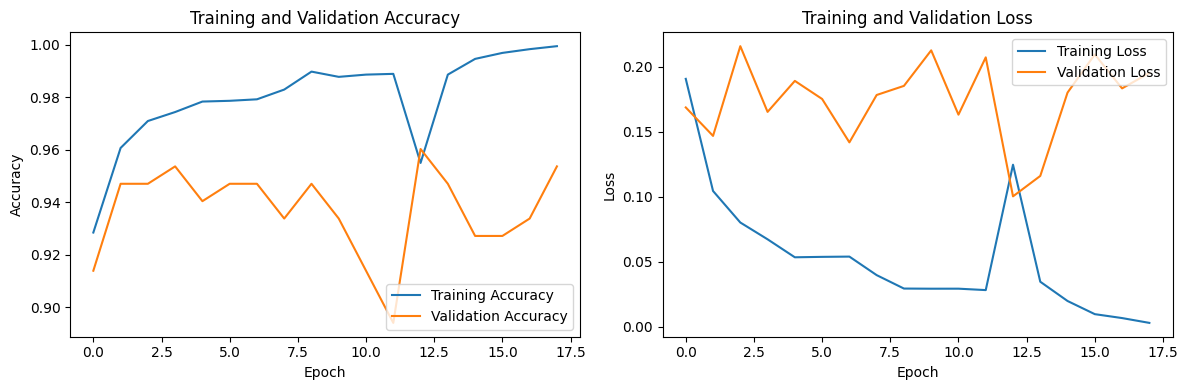


--- 2. ROC Curve and AUC Results ---


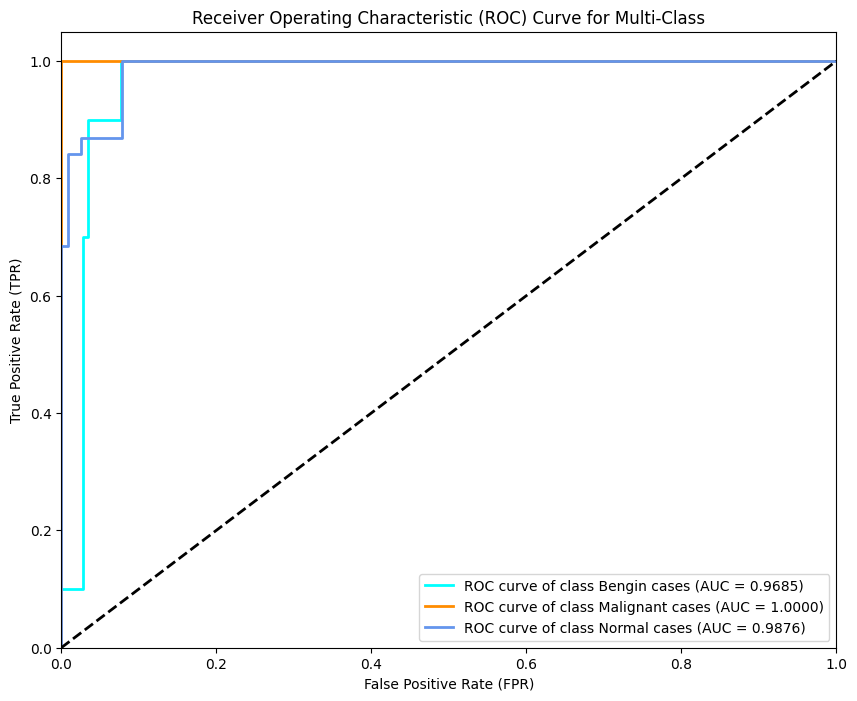


--- 3. Final Classification Report ---
                 precision    recall  f1-score   support

   Bengin cases     0.6364    0.7000    0.6667        10
Malignant cases     0.9906    1.0000    0.9953       105
   Normal cases     0.9167    0.8684    0.8919        38

       accuracy                         0.9477       153
      macro avg     0.8479    0.8561    0.8513       153
   weighted avg     0.9491    0.9477    0.9481       153



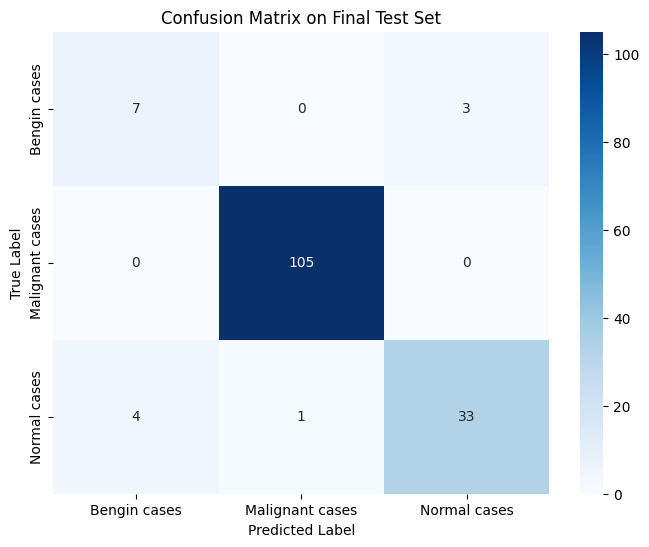


--- Evaluation Process Complete ---


In [10]:
# 1. FINAL MODEL EVALUATION (Cell 10 এর প্রথম অংশ)
print("\n## 10. 📊 Final Evaluation on the Reserved Final Test Set")
test_results = final_model.evaluate(final_test_generator, verbose=1) # Cell 10

# Get predictions and true classes for detailed metrics
test_steps = final_test_generator.n // final_test_generator.batch_size + (final_test_generator.n % final_test_generator.batch_size != 0)
predictions = final_model.predict(final_test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = final_test_generator.classes[:len(predicted_classes)]

# --- 2. COMBINE TRAINING HISTORIES (Cell 11 এর প্রথম অংশ) ---
try:
    acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
    loss = history.history['loss'] + history_fine_tune.history['loss']
    val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']
    epochs_range = range(len(acc))
except NameError:
    # যদি Fine-tuning History না থাকে, তবে শুধু Initial History ব্যবহার করা হচ্ছে
    print("Warning: Combining history failed. Using initial history only.")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

print("Training histories combined for plotting.")

# --- 3. অ্যাক্যুরিসি এবং লস কার্ভ (Accuracy and Loss Curves) ---
# [Cell 11 এর 1 নম্বর অংশ]
plt.figure(figsize=(12, 4))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show() 

# --- 4. ROC কার্ভ (Receiver Operating Characteristic Curve) ---
# [Cell 11 এর 2 নম্বর অংশ]
print("\n--- 2. ROC Curve and AUC Results ---")

# Convert true classes to one-hot encoding for ROC AUC calculation
y_true_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=NUM_CLASSES)

# Plotting ROC Curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw = 2
roc_auc = dict()

for i, color in zip(range(NUM_CLASSES), colors):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr, tpr)
    
    plt.plot(
        fpr,
        tpr,
        color=color,
        lw=lw,
        label=f'ROC curve of class {CLASS_NAMES[i]} (AUC = {roc_auc[i]:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show() 

# --- 5. ফলাফল মেট্রিক্স (Classification Report & Confusion Matrix) ---
# [Cell 10 ও Cell 11 এর 3 নম্বর অংশ]
print("\n--- 3. Final Classification Report ---")

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES, digits=4))

# Confusion Matrix (Visualization)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix on Final Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 

print("\n--- Evaluation Process Complete ---")

****Result graph- ROC Curve, Confusion Matrix etc.****